In [1]:
from pydwf import DwfLibrary, DwfAnalogOutNode, DwfAnalogOutFunction
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessary for older matplotlib
from matplotlib import cm
import time
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from scipy.signal import correlate
import pandas as pd
from gmeasure import GMeasure

dwf = DwfLibrary()

In [51]:
def range_finder(signal):
    range_simple = abs(np.max(signal) - np.min(signal))
    return range_simple


def linear_fit_function(x_data, y_data):
    """
    Fit a linear function y = a*x + b using curve_fit and return
    both the fitted function and the parameters.
    """

    # Define linear model
    def linear_model(x, a, b):
        return a * x + b

    # Fit
    popt, pcov = curve_fit(linear_model, x_data, y_data)

    # Extract parameters
    a, b = popt

    # Build fitted function
    def f(x):
        return (x-b)/a

    return f, (a, b)

In [35]:
def measure_ac_gain_vin_sweep(
    vin_list,
    freq=1000,
    n_meas=10,
    printbool=False
):
    """
    Sweep AC gain across a range of input amplitudes.
    The FIRST sweep point interacts to detect AD2 device order.
    Later points reuse prefer_first_device.

    Parameters
    ----------
    vin_list : list or array
        Input amplitudes (Volts) to test.
    freq : float
        Frequency of the sine wave (Hz).
    n_meas : int
        Number of repeated measurements per amplitude.
    printbool : bool
        If True, plots the last measurement per voltage.

    Returns
    -------
    results : dict
        Contains vin, gain, vin_range, vout_range, device_preference.
    """

    # Storage
    sweep_vins = []
    sweep_gain = []
    sweep_vin_range = []
    sweep_vout_range = []
    sweep_gain_std = []
    sweep_vin_range_std = []
    sweep_vout_range_std = []

    prefer_bool = None   # Will be filled after first device detection

    # Loop over input amplitudes
    for j, v_in in enumerate(vin_list):

        print(f"\n========== Vin sweep {j+1}/{len(vin_list)} : {v_in} V ==========\n")

        # Measurement object
        gm = GMeasure(
            osc_channels1=[1, 1],
            out_channels1=[1, 0],
            ad_2=2,
            v_out1=[v_in, 0],
            waveforms_1=["Sine", "DC"],
            freq1=[freq, 0],
            wavelengths=1,
            prefer_first_device=prefer_bool,
            tsleep=0.5
        )

        # First measurement → perform autodetection
        if j == 0:
            gm.measure2()
            prefer_bool = gm.response
            print(f"\nDevice order detected: prefer_first_device = {prefer_bool}\n")

        gains = []
        vin_ranges = []
        vout_ranges = []

        # Measure n_meas times for averaging
        for i in range(n_meas):
            
            gm.measure2()

            # Extract data (second device)
            v_in_sig = np.array(gm.data1[1])   # input channel
            v_out_sig = np.array(gm.data1[0])  # output channel

            vin_range  = range_finder(v_in_sig)
            vout_range = range_finder(v_out_sig)
            gain       = vout_range / vin_range if vin_range != 0 else np.nan

            gains.append(gain)
            vin_ranges.append(vin_range)
            vout_ranges.append(vout_range)

            # Optional plot
            if printbool and i == n_meas - 1:
                t = gm.t[:len(v_in_sig)]
                plt.figure(figsize=(7,4))
                plt.scatter(t, v_in_sig*1000, s=2, label="Input")
                plt.scatter(t, v_out_sig, s=2, label="Output")
                plt.title(f"Vin = {v_in} V  (Gain = {gain:.3f})")
                plt.xlabel("Time (s)")
                plt.ylabel("Voltage (mV)")
                plt.legend()
                plt.tight_layout()
                plt.show()
                
        # Store averages
        sweep_vins.append(v_in)
        sweep_gain.append(np.mean(gains))
        sweep_gain_std.append(np.std(gains))
        sweep_vin_range.append(np.mean(vin_ranges))
        sweep_vin_range_std.append(np.std(vin_ranges))
        sweep_vout_range.append(np.mean(vout_ranges))
        sweep_vout_range_std.append(np.std(vout_ranges))

        print(f"Vin {v_in} V → Gain = {np.nanmean(gains):.3f}")

    # Return all results
    return {
        "vin": sweep_vins,
        "gain": sweep_gain,
        "gain_std": sweep_gain_std,
        "vin_range": sweep_vin_range,
        "vin_range_std": sweep_vin_range_std,
        "vout_range": sweep_vout_range,
        "vout_range_std": sweep_vout_range_std,
        "device_preference": prefer_bool
    }


In [47]:
vlist = np.linspace(0.05,0.2,50)
amplifier_data = measure_ac_gain_vin_sweep(freq=5000,vin_list= vlist, n_meas=10)


========== Vin sweep 1/50 : 0.05 V ==========

Detected Devices:
  Device 0: Serial 210321AA27B7
  Device 1: Serial 210321B5D70C
→ Device 1: 210321B5D70C | Device 2: 210321AA27B7
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.

Device order detected: prefer_first_device = False

DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Volta

In [53]:
gain_10 = pd.read_csv("transfer_func_data_gain10_5000Hz_10n.csv")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

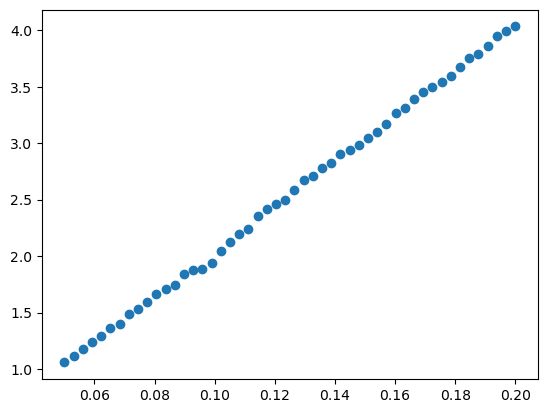

In [57]:
plt.scatter(gain_10["vin"], gain_10["vout_range"])

In [59]:
f, params = linear_fit_function(gain_10['vin']*2, gain_10['vout_range'])

In [60]:
print(params)

(np.float64(10.024579938249904), np.float64(0.03593075008361179))
